<a href="https://colab.research.google.com/github/choccoba/ITLAS/blob/main/ITLAS_Session2_FM_GSEA_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITLAS Session 2: FM-GSEA & Pathway Analysis (version 3)

**목적**: 24개 Leiden 클러스터의 pathway enrichment 분석

**Runtime**: A100 GPU + High RAM

---

### Step 0 완료 사항
- Leiden clustering: 24 clusters (resolution=0.438)
- 파일: `GSE182159_with_leiden.h5ad`

### 핵심 클러스터 (Step 0에서 식별)
- **IT-exclusive** (NL < 1%): Clusters 9, 14, 22
- **NL-dominant** (NL > 97%): Clusters 15, 18
- **IT-enriched** (IT > 30%): Clusters 20, 23

### Disease Stages
- NL: Normal Liver (healthy controls)
- IT: Immune Tolerant
- IA: Immune Active
- AR: Acute Resolved
- CR: Chronic Resolved (low HBsAg, no HBV DNA)

---
## 1. Environment Setup

In [1]:
# GPU 및 메모리 확인
!nvidia-smi

import psutil
print(f"\n✓ Available RAM: {psutil.virtual_memory().available / 1e9:.1f} GB")

Fri Jan 30 10:21:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   36C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# 필수 패키지 설치
!pip install -q scanpy anndata gseapy
!pip install -q leidenalg igraph

print("\n✓ 패키지 설치 완료")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 131.6 MB/s eta 0:00:00

✓ 패키지 설치 완료


In [3]:
# 라이브러리 임포트
import scanpy as sc
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scanpy 설정
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(8, 6))

print(f"✓ scanpy: {sc.__version__}")
print(f"✓ gseapy: {gp.__version__}")
print("✓ 라이브러리 로드 완료")

✓ scanpy: 1.12
✓ gseapy: 1.1.11
✓ 라이브러리 로드 완료


---
## 2. Google Drive Mount & Data Loading

In [4]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

print("\n✓ Google Drive 마운트 완료")

Mounted at /content/drive

✓ Google Drive 마운트 완료


In [5]:
# ========================================
# 경로 설정
# ========================================

base_path = Path('/content/drive/MyDrive/ITLAS')
data_path = base_path / 'data' / 'processed'
results_path = base_path / 'results'

# Step 0에서 생성한 파일
h5ad_file = data_path / 'GSE182159_with_leiden.h5ad'

# Session 2 출력 폴더 (자동 생성)
session2_path = results_path / 'session2_pathway'
for folder in ['fm_gsea', 'traditional_gsea', 'comparison', 'figures']:
    (session2_path / folder).mkdir(parents=True, exist_ok=True)

# 경로 확인
print("="*50)
print("경로 설정 확인")
print("="*50)
print(f"\n  h5ad 파일: {h5ad_file}")
print(f"  존재 여부: {'✓' if h5ad_file.exists() else '✗ 파일 없음!'}")
print(f"\n  출력 폴더: {session2_path} ✓")

경로 설정 확인

  h5ad 파일: /content/drive/MyDrive/ITLAS/data/processed/GSE182159_with_leiden.h5ad
  존재 여부: ✓

  출력 폴더: /content/drive/MyDrive/ITLAS/results/session2_pathway ✓


In [6]:
# 데이터 로드
print(f"Loading: {h5ad_file.name}")
print("대용량 파일이므로 몇 분 소요됩니다...\n")

adata = sc.read_h5ad(h5ad_file)

print("="*50)
print("데이터 로드 완료")
print("="*50)
print(f"  Cells: {adata.shape[0]:,}")
print(f"  Genes: {adata.shape[1]:,}")
print(f"\n  obs columns: {list(adata.obs.columns)}")
print(f"\n  leiden 클러스터 수: {adata.obs['leiden'].nunique()}")
print(f"  Stage 종류: {adata.obs['Stage'].unique().tolist()}")

Loading: GSE182159_with_leiden.h5ad
대용량 파일이므로 몇 분 소요됩니다...

데이터 로드 완료
  Cells: 243,000
  Genes: 24,452

  obs columns: ['sample', 'tissue', 'Stage', 'IT_cluster_21', 'IT_cluster_23', 'IT_cluster_25', 'IT_nk_collapse', 'IT_IT_signature', 'GSM_ID', 'IT_score_v2', 'IT_score_v3', 'IT_score_v4', 'IT_signature_final', 'IT_like', 'PW_mTOR_signaling', 'PW_glycolysis', 'PW_oxidative_phosphorylation', 'PW_nk_cell_cytotoxicity', 'PW_il15_signaling', 'PW_b_cell_differentiation', 'leiden']

  leiden 클러스터 수: 24
  Stage 종류: ['IT', 'AR', 'IA', 'NL', 'AC']


---
## 3. Define Key Clusters

In [7]:
# ========================================
# 핵심 분석 대상 클러스터 정의 (Step 0 결과 기반)
# ========================================

CLUSTER_COL = 'leiden'

# IT-exclusive clusters (NL < 1%)
IT_EXCLUSIVE = [9, 14, 22]

# NL-dominant clusters (NL > 97%)
NL_DOMINANT = [15, 18]

# IT-enriched clusters (IT > 30%)
IT_ENRICHED = [20, 23]

# Disease-active clusters
DISEASE_ACTIVE = [4, 5, 8, 13]

# 전체 분석 대상
ALL_KEY_CLUSTERS = IT_EXCLUSIVE + NL_DOMINANT + IT_ENRICHED

print("="*50)
print("분석 대상 클러스터")
print("="*50)
print(f"\n  [IT-exclusive] (NL < 1%): {IT_EXCLUSIVE}")
print(f"    - C9:  NL=0.03%, CR-dominant")
print(f"    - C14: NL=0.36%, CR-enriched")
print(f"    - C22: NL=0.00%, IT=12.4%")
print(f"\n  [NL-dominant] (NL > 97%): {NL_DOMINANT}")
print(f"    - C15: NL=97.4%, homeostatic")
print(f"    - C18: NL=99.9%, tissue-resident")
print(f"\n  [IT-enriched] (IT > 30%): {IT_ENRICHED}")
print(f"    - C20: IT=57.4%, IT-specific")
print(f"    - C23: IT=33.5%, tolerogenic")

분석 대상 클러스터

  [IT-exclusive] (NL < 1%): [9, 14, 22]
    - C9:  NL=0.03%, CR-dominant
    - C14: NL=0.36%, CR-enriched
    - C22: NL=0.00%, IT=12.4%

  [NL-dominant] (NL > 97%): [15, 18]
    - C15: NL=97.4%, homeostatic
    - C18: NL=99.9%, tissue-resident

  [IT-enriched] (IT > 30%): [20, 23]
    - C20: IT=57.4%, IT-specific
    - C23: IT=33.5%, tolerogenic


---
## 4. Marker Gene Analysis (Rank Genes)

In [9]:
# leiden 컬럼을 category 타입으로 변환
adata.obs['leiden'] = adata.obs['leiden'].astype(str).astype('category')

print(f"✓ leiden dtype: {adata.obs['leiden'].dtype}")
print(f"  categories: {adata.obs['leiden'].cat.categories.tolist()}")

✓ leiden dtype: category
  categories: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']


In [10]:
# 전체 클러스터에 대해 marker genes 계산
print("Marker gene 분석 중... (몇 분 소요)")

sc.tl.rank_genes_groups(
    adata,
    groupby=CLUSTER_COL,
    method='wilcoxon',
    pts=True
)

print("\n✓ Marker gene 분석 완료")

Marker gene 분석 중... (몇 분 소요)
ranking genes
    finished (0:19:05)

✓ Marker gene 분석 완료


In [11]:
# 주요 클러스터의 top marker genes 확인
print("="*60)
print("주요 클러스터 Top 10 Marker Genes")
print("="*60)

for cluster in ALL_KEY_CLUSTERS:
    print(f"\n### Cluster {cluster} ###")
    markers = sc.get.rank_genes_groups_df(adata, group=str(cluster)).head(10)
    for _, row in markers.iterrows():
        print(f"  {row['names']}: logFC={row['logfoldchanges']:.2f}, pval={row['pvals_adj']:.2e}")

주요 클러스터 Top 10 Marker Genes

### Cluster 9 ###
  EEF1A1: logFC=1.21, pval=0.00e+00
  TPT1: logFC=1.30, pval=0.00e+00
  TXNIP: logFC=2.54, pval=0.00e+00
  NACA: logFC=1.27, pval=0.00e+00
  MT-CYB: logFC=1.08, pval=0.00e+00
  RACK1: logFC=1.24, pval=0.00e+00
  MT-ND4L: logFC=1.09, pval=0.00e+00
  CIRBP: logFC=1.69, pval=0.00e+00
  FAU: logFC=0.86, pval=0.00e+00
  MT-ND1: logFC=1.17, pval=0.00e+00

### Cluster 14 ###
  CD74: logFC=4.45, pval=0.00e+00
  CD79A: logFC=6.71, pval=0.00e+00
  HLA-DRA: logFC=5.61, pval=0.00e+00
  CD37: logFC=2.76, pval=0.00e+00
  HLA-DPB1: logFC=3.68, pval=0.00e+00
  HLA-DRB1: logFC=3.80, pval=0.00e+00
  HLA-DPA1: logFC=3.42, pval=0.00e+00
  RCSD1: logFC=3.41, pval=0.00e+00
  LINC00926: logFC=6.06, pval=0.00e+00
  HLA-DRB5: logFC=4.09, pval=0.00e+00

### Cluster 22 ###
  NEAT1: logFC=6.05, pval=0.00e+00
  VCAN: logFC=7.00, pval=0.00e+00
  CSF3R: logFC=6.34, pval=0.00e+00
  CYBB: logFC=5.68, pval=0.00e+00
  ZEB2: logFC=4.17, pval=0.00e+00
  FCN1: logFC=5.77, pval

In [12]:
# Marker genes 저장
all_markers = {}
for cluster in range(24):
    df = sc.get.rank_genes_groups_df(adata, group=str(cluster))
    df['cluster'] = cluster
    all_markers[cluster] = df

# 전체 저장
all_markers_df = pd.concat(all_markers.values())
all_markers_df.to_csv(session2_path / 'fm_gsea' / 'all_cluster_markers.csv', index=False)
print(f"✓ 저장: all_cluster_markers.csv")

✓ 저장: all_cluster_markers.csv


---
## 5. FM-GSEA: Pathway Enrichment Analysis

In [13]:
# Gene set 데이터베이스 정의
GENE_SETS = {
    'kegg': 'KEGG_2021_Human',
    'hallmark': 'MSigDB_Hallmark_2020',
    'go_bp': 'GO_Biological_Process_2023',
    'reactome': 'Reactome_2022'
}

print("사용할 Gene Set 데이터베이스:")
for name, db in GENE_SETS.items():
    print(f"  - {name}: {db}")

사용할 Gene Set 데이터베이스:
  - kegg: KEGG_2021_Human
  - hallmark: MSigDB_Hallmark_2020
  - go_bp: GO_Biological_Process_2023
  - reactome: Reactome_2022


In [14]:
# ========================================
# FM-GSEA 실행: 모든 주요 클러스터
# ========================================

fm_gsea_results = {}

for cluster in ALL_KEY_CLUSTERS:
    print(f"\n{'='*60}")
    print(f"Cluster {cluster} 분석")
    print(f"{'='*60}")

    # Marker genes 추출 (top 200)
    markers = sc.get.rank_genes_groups_df(adata, group=str(cluster)).head(200)
    gene_list = markers['names'].tolist()
    print(f"  Marker genes: {len(gene_list)}개")

    # 각 gene set에 대해 enrichment
    cluster_results = {}

    for gs_name, gs_db in GENE_SETS.items():
        print(f"  [{gs_name}]...", end=" ")
        try:
            enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=gs_db,
                organism='Human',
                outdir=None
            )
            cluster_results[gs_name] = enr.results
            n_sig = (enr.results['Adjusted P-value'] < 0.05).sum()
            print(f"✓ ({n_sig} significant)")
        except Exception as e:
            print(f"✗ {str(e)[:30]}")
            cluster_results[gs_name] = pd.DataFrame()

    fm_gsea_results[cluster] = cluster_results

print("\n" + "="*60)
print("FM-GSEA 분석 완료")
print("="*60)


Cluster 9 분석
  Marker genes: 200개
  [kegg]... ✓ (11 significant)
  [hallmark]... ✓ (4 significant)
  [go_bp]... ✓ (20 significant)
  [reactome]... ✓ (43 significant)

Cluster 14 분석
  Marker genes: 200개
  [kegg]... ✓ (47 significant)
  [hallmark]... ✓ (6 significant)
  [go_bp]... ✓ (89 significant)
  [reactome]... ✓ (33 significant)

Cluster 22 분석
  Marker genes: 200개
  [kegg]... ✓ (48 significant)
  [hallmark]... ✓ (13 significant)
  [go_bp]... ✓ (286 significant)
  [reactome]... ✓ (136 significant)

Cluster 15 분석
  Marker genes: 200개
  [kegg]... ✓ (89 significant)
  [hallmark]... ✓ (25 significant)
  [go_bp]... ✓ (237 significant)
  [reactome]... ✓ (108 significant)

Cluster 18 분석
  Marker genes: 200개
  [kegg]... ✓ (53 significant)
  [hallmark]... ✓ (15 significant)
  [go_bp]... ✓ (164 significant)
  [reactome]... ✓ (144 significant)

Cluster 20 분석
  Marker genes: 200개
  [kegg]... ✓ (71 significant)
  [hallmark]... ✓ (22 significant)
  [go_bp]... ✓ (446 significant)
  [reactome]... ✓

In [15]:
# Top pathways 출력
print("="*60)
print("주요 클러스터 Top 5 KEGG Pathways")
print("="*60)

for cluster in ALL_KEY_CLUSTERS:
    print(f"\n### Cluster {cluster} ###")
    if cluster in fm_gsea_results and 'kegg' in fm_gsea_results[cluster]:
        df = fm_gsea_results[cluster]['kegg']
        if len(df) > 0:
            top5 = df.head(5)
            for _, row in top5.iterrows():
                print(f"  • {row['Term'][:45]}... (p={row['Adjusted P-value']:.2e})")
        else:
            print("  결과 없음")

주요 클러스터 Top 5 KEGG Pathways

### Cluster 9 ###
  • Oxidative phosphorylation... (p=1.28e-03)
  • Hematopoietic cell lineage... (p=5.05e-03)
  • Epstein-Barr virus infection... (p=6.97e-03)
  • Diabetic cardiomyopathy... (p=6.97e-03)
  • Parkinson disease... (p=6.97e-03)

### Cluster 14 ###
  • Hematopoietic cell lineage... (p=4.63e-17)
  • Intestinal immune network for IgA production... (p=2.34e-15)
  • Asthma... (p=5.91e-15)
  • Leishmaniasis... (p=6.24e-14)
  • Allograft rejection... (p=6.40e-14)

### Cluster 22 ###
  • Osteoclast differentiation... (p=9.62e-08)
  • Leishmaniasis... (p=4.97e-07)
  • Tuberculosis... (p=2.28e-06)
  • Phagosome... (p=1.95e-05)
  • Hepatitis B... (p=1.87e-04)

### Cluster 15 ###
  • Osteoclast differentiation... (p=9.86e-08)
  • Apoptosis... (p=1.98e-07)
  • Epstein-Barr virus infection... (p=1.15e-06)
  • Cellular senescence... (p=2.99e-06)
  • Pathways in cancer... (p=3.80e-06)

### Cluster 18 ###
  • Antigen processing and presentation... (p=2.86e-16)

---
## 6. IT-Exclusive vs NL-Dominant Comparison

In [16]:
# IT-exclusive와 NL-dominant 클러스터 pathway 비교

def get_top_pathways(results, clusters, gs_name='kegg', n=20):
    """클러스터 그룹의 top pathways 추출"""
    all_pathways = []
    for c in clusters:
        if c in results and gs_name in results[c]:
            df = results[c][gs_name]
            if len(df) > 0:
                top = df.head(n)[['Term', 'Adjusted P-value', 'Odds Ratio']].copy()
                top['Cluster'] = c
                all_pathways.append(top)
    if all_pathways:
        return pd.concat(all_pathways)
    return pd.DataFrame()

print("="*60)
print("IT-EXCLUSIVE vs NL-DOMINANT Pathway Comparison")
print("="*60)

# IT-exclusive pathways
print("\n### IT-Exclusive Clusters (9, 14, 22) ###")
it_pathways = get_top_pathways(fm_gsea_results, IT_EXCLUSIVE, 'kegg', 10)
if len(it_pathways) > 0:
    print(it_pathways[['Cluster', 'Term', 'Adjusted P-value']].to_string())

# NL-dominant pathways
print("\n### NL-Dominant Clusters (15, 18) ###")
nl_pathways = get_top_pathways(fm_gsea_results, NL_DOMINANT, 'kegg', 10)
if len(nl_pathways) > 0:
    print(nl_pathways[['Cluster', 'Term', 'Adjusted P-value']].to_string())

IT-EXCLUSIVE vs NL-DOMINANT Pathway Comparison

### IT-Exclusive Clusters (9, 14, 22) ###
   Cluster                                                    Term  Adjusted P-value
0        9                               Oxidative phosphorylation      1.280414e-03
1        9                              Hematopoietic cell lineage      5.052971e-03
2        9                            Epstein-Barr virus infection      6.971663e-03
3        9                                 Diabetic cardiomyopathy      6.971663e-03
4        9                                       Parkinson disease      6.971663e-03
5        9                                                 Measles      1.363441e-02
6        9                                           RNA transport      1.363441e-02
7        9                 Human T-cell leukemia virus 1 infection      3.213108e-02
8        9                                           Prion disease      3.213108e-02
9        9                                  FoxO signaling p

In [17]:
# 대사 관련 pathway 필터링
metabolic_keywords = ['Oxidative', 'Glycoly', 'TCA', 'ATP', 'Mitochond',
                      'Electron', 'Respiratory', 'Metabolism', 'OXPHOS',
                      'mTOR', 'Fatty', 'Amino acid']

print("="*60)
print("METABOLIC PATHWAY ENRICHMENT")
print("="*60)

for cluster in ALL_KEY_CLUSTERS:
    print(f"\n### Cluster {cluster} ###")

    for gs_name in ['kegg', 'hallmark']:
        if cluster in fm_gsea_results and gs_name in fm_gsea_results[cluster]:
            df = fm_gsea_results[cluster][gs_name]
            if len(df) > 0:
                mask = df['Term'].str.contains('|'.join(metabolic_keywords), case=False, na=False)
                metab = df[mask][['Term', 'Adjusted P-value']].head(5)
                if len(metab) > 0:
                    print(f"  [{gs_name}]")
                    for _, row in metab.iterrows():
                        print(f"    • {row['Term'][:40]}... (p={row['Adjusted P-value']:.2e})")

METABOLIC PATHWAY ENRICHMENT

### Cluster 9 ###
  [kegg]
    • Oxidative phosphorylation... (p=1.28e-03)
    • Non-alcoholic fatty liver disease... (p=1.67e-01)
    • Drug metabolism... (p=3.86e-01)
    • Pyrimidine metabolism... (p=4.22e-01)
    • Purine metabolism... (p=4.96e-01)
  [hallmark]
    • Oxidative Phosphorylation... (p=1.19e-04)
    • heme Metabolism... (p=9.80e-02)
    • PI3K/AKT/mTOR  Signaling... (p=2.32e-01)
    • Fatty Acid Metabolism... (p=4.65e-01)
    • Glycolysis... (p=6.96e-01)

### Cluster 14 ###
  [kegg]
    • Choline metabolism in cancer... (p=6.36e-02)
    • Phosphonate and phosphinate metabolism... (p=1.73e-01)
    • Inositol phosphate metabolism... (p=3.61e-01)
    • Glycerophospholipid metabolism... (p=4.43e-01)
    • Purine metabolism... (p=5.50e-01)
  [hallmark]
    • PI3K/AKT/mTOR  Signaling... (p=2.66e-02)
    • mTORC1 Signaling... (p=6.00e-01)
    • Glycolysis... (p=7.51e-01)
    • Xenobiotic Metabolism... (p=8.67e-01)
    • Oxidative Phosphorylation.

---
## 7. Visualization

In [18]:
# Pathway enrichment heatmap 함수
def plot_pathway_heatmap(results, clusters, gene_set='kegg', top_n=15, title=None):
    """
    클러스터별 pathway enrichment heatmap
    """
    # Top pathways 수집
    all_pathways = []
    for cluster in clusters:
        if cluster in results and gene_set in results[cluster]:
            df = results[cluster][gene_set]
            if len(df) > 0:
                top = df.head(top_n)['Term'].tolist()
                all_pathways.extend(top)

    # 중복 제거
    seen = set()
    unique_pathways = []
    for p in all_pathways:
        if p not in seen:
            seen.add(p)
            unique_pathways.append(p)
    unique_pathways = unique_pathways[:25]

    if len(unique_pathways) == 0:
        print("No pathways found")
        return None

    # Matrix 생성
    matrix = pd.DataFrame(index=unique_pathways, columns=[f'C{c}' for c in clusters])

    for cluster in clusters:
        col = f'C{cluster}'
        if cluster in results and gene_set in results[cluster]:
            df = results[cluster][gene_set]
            for pathway in unique_pathways:
                if pathway in df['Term'].values:
                    pval = df[df['Term'] == pathway]['Adjusted P-value'].values[0]
                    matrix.loc[pathway, col] = -np.log10(pval + 1e-300)
                else:
                    matrix.loc[pathway, col] = 0
        else:
            matrix[col] = 0

    matrix = matrix.astype(float)

    # Plot
    fig, ax = plt.subplots(figsize=(10, max(8, len(unique_pathways) * 0.35)))
    short_names = [p[:40] + '...' if len(p) > 40 else p for p in unique_pathways]

    sns.heatmap(matrix, cmap='YlOrRd', annot=True, fmt='.1f',
                xticklabels=matrix.columns,
                yticklabels=short_names,
                ax=ax, cbar_kws={'label': '-log10(adj.p)'})

    ax.set_title(title or f'{gene_set.upper()} Pathway Enrichment')
    plt.tight_layout()

    return fig

print("✓ Heatmap 함수 정의 완료")

✓ Heatmap 함수 정의 완료


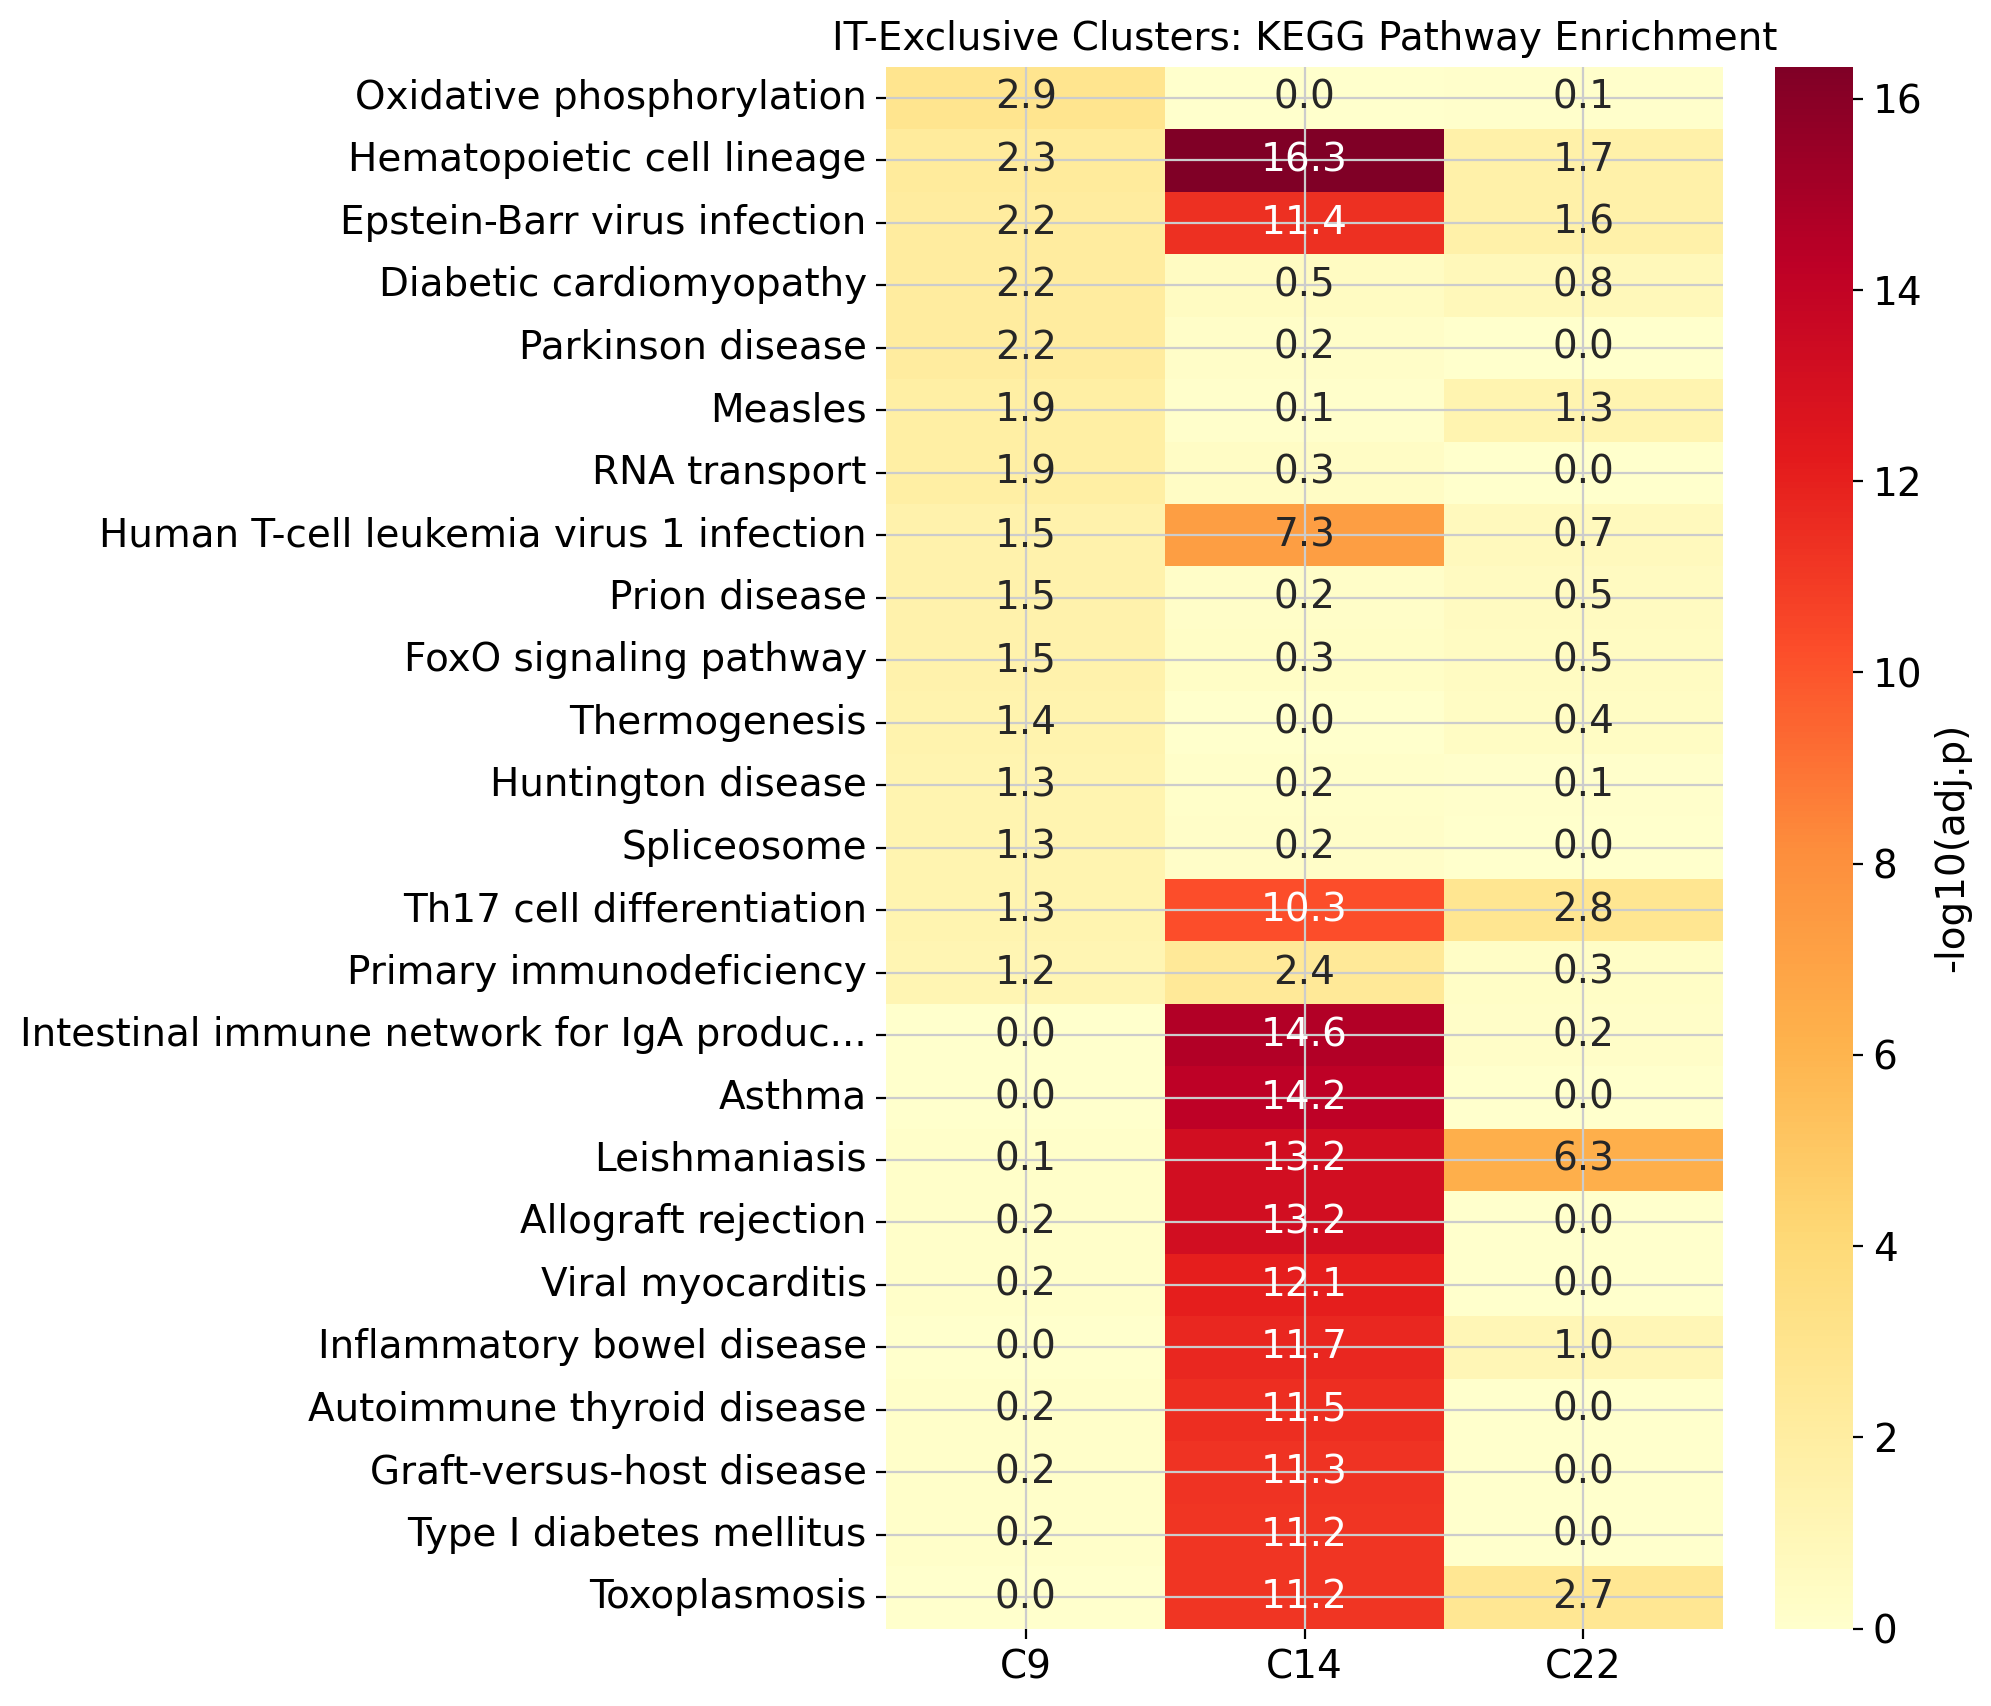


✓ 저장 완료


In [19]:
# IT-exclusive clusters: KEGG heatmap
fig1 = plot_pathway_heatmap(
    fm_gsea_results, IT_EXCLUSIVE, 'kegg',
    title='IT-Exclusive Clusters: KEGG Pathway Enrichment'
)
if fig1:
    fig1.savefig(session2_path / 'figures' / 'IT_exclusive_KEGG_heatmap.png',
                 dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ 저장 완료")

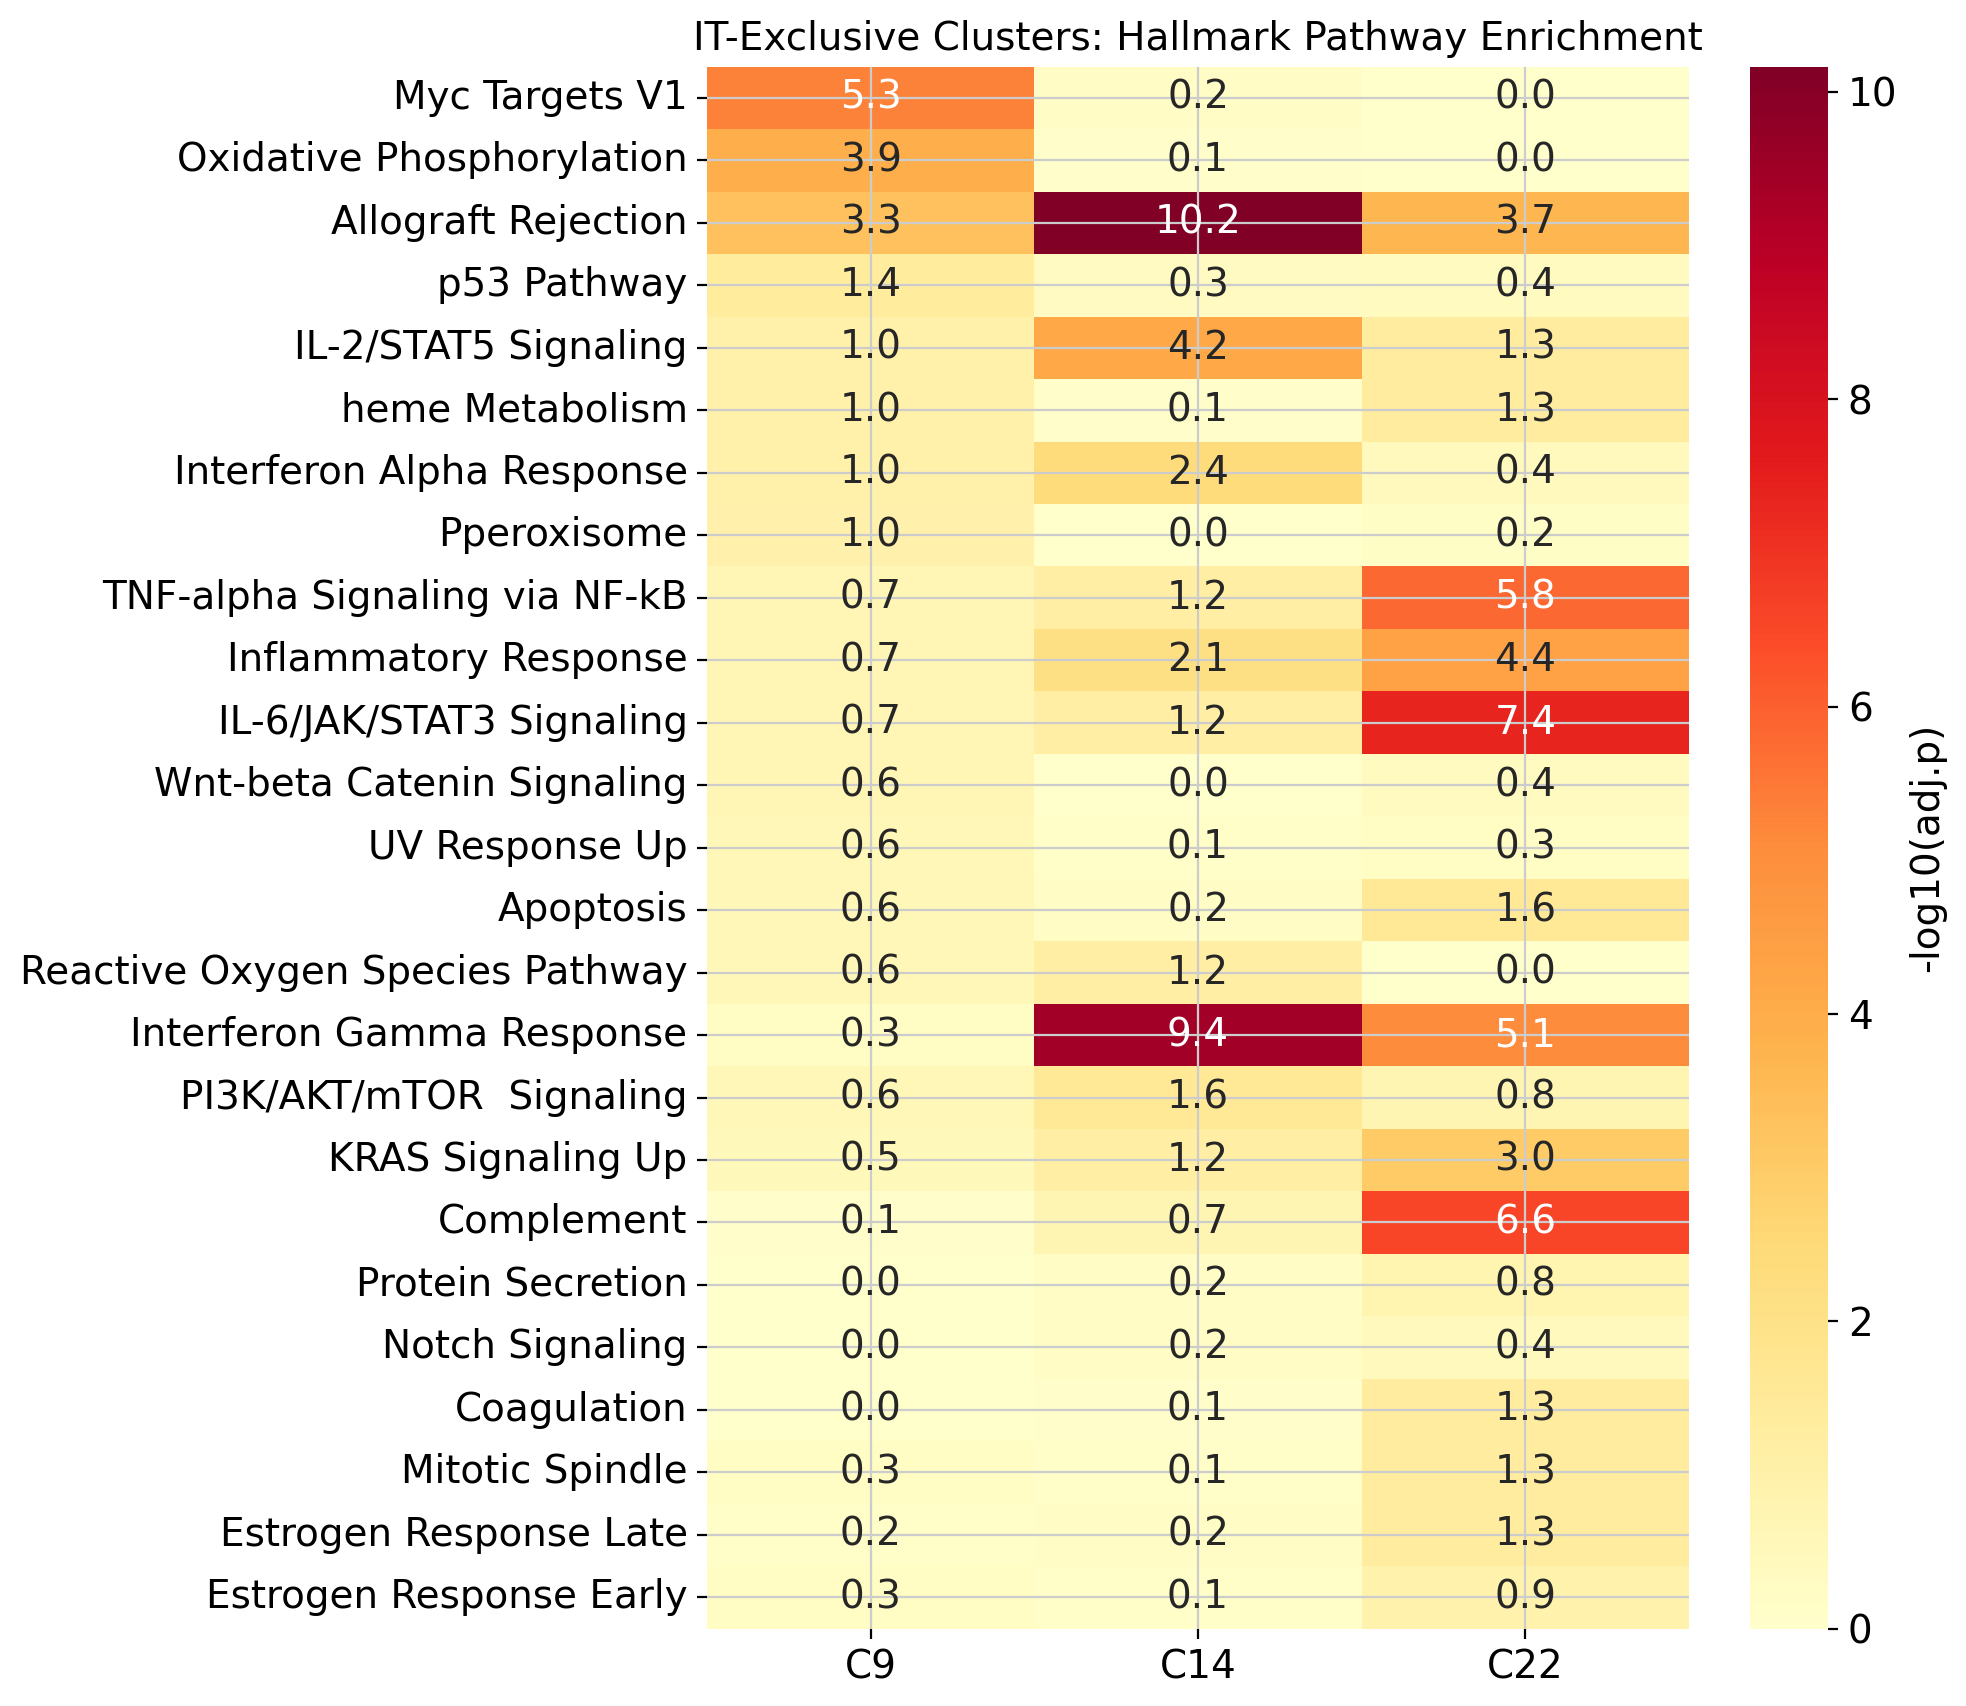

In [20]:
# IT-exclusive clusters: Hallmark heatmap
fig2 = plot_pathway_heatmap(
    fm_gsea_results, IT_EXCLUSIVE, 'hallmark',
    title='IT-Exclusive Clusters: Hallmark Pathway Enrichment'
)
if fig2:
    fig2.savefig(session2_path / 'figures' / 'IT_exclusive_Hallmark_heatmap.png',
                 dpi=150, bbox_inches='tight')
    plt.show()

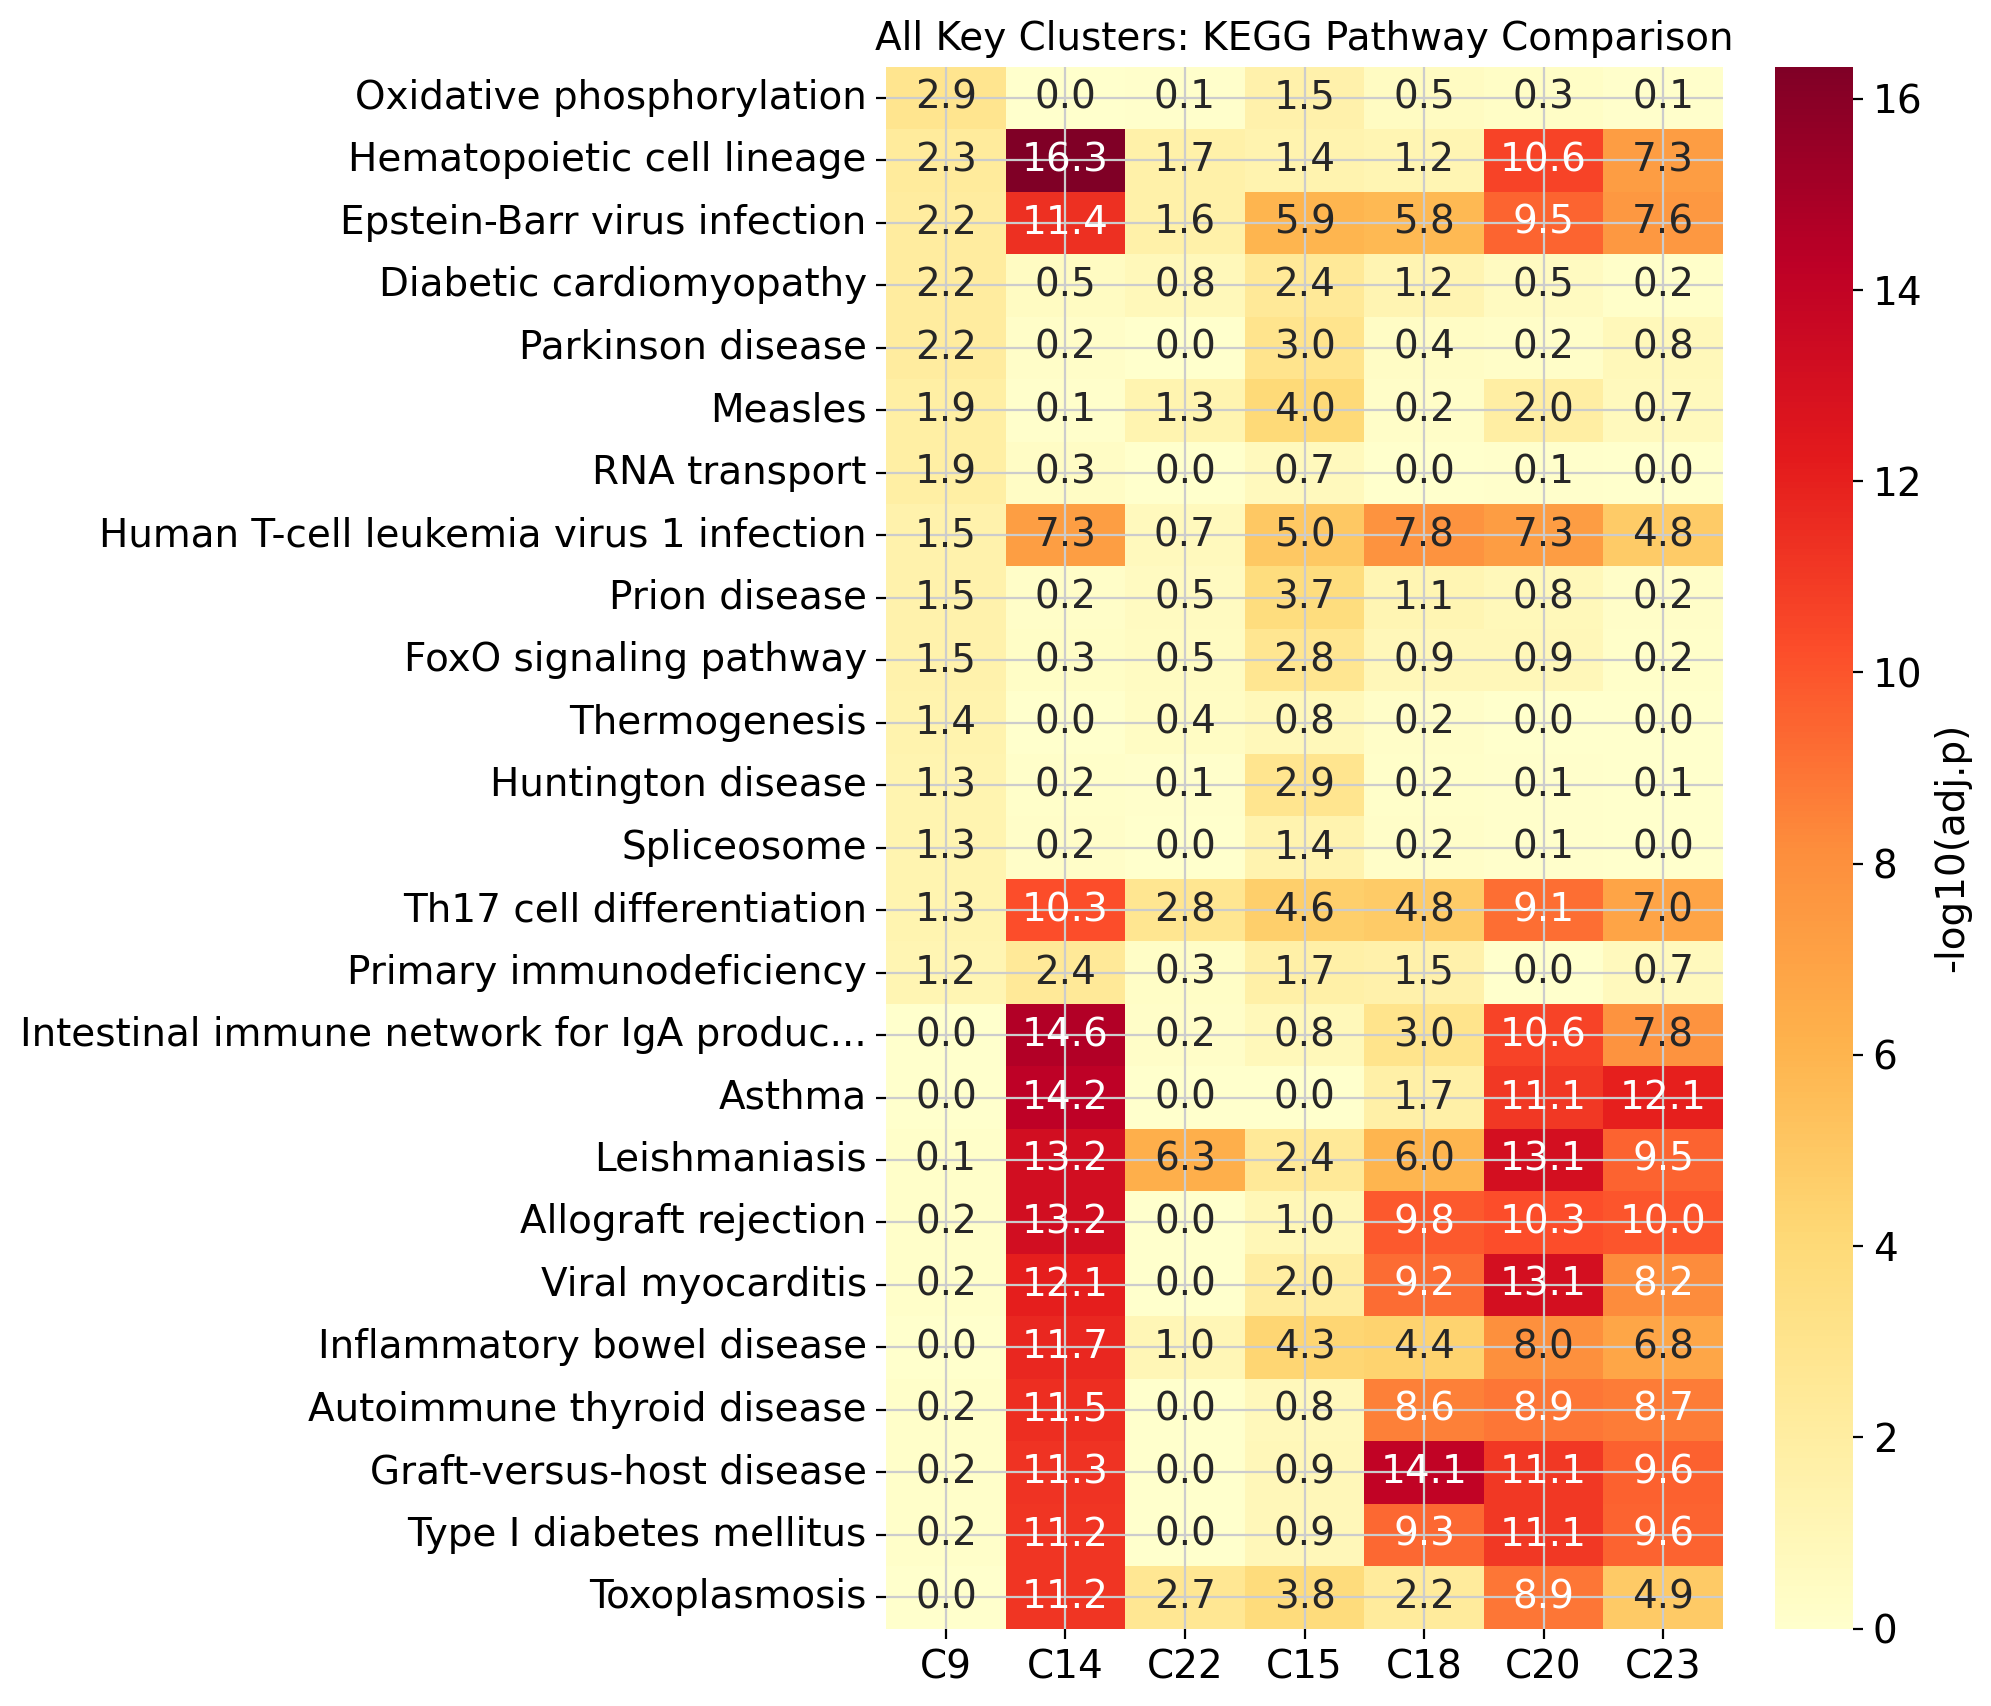

In [21]:
# 전체 주요 클러스터 비교
fig3 = plot_pathway_heatmap(
    fm_gsea_results, ALL_KEY_CLUSTERS, 'kegg',
    title='All Key Clusters: KEGG Pathway Comparison'
)
if fig3:
    fig3.savefig(session2_path / 'figures' / 'All_key_clusters_KEGG_heatmap.png',
                 dpi=150, bbox_inches='tight')
    plt.show()

Available markers: 19/19


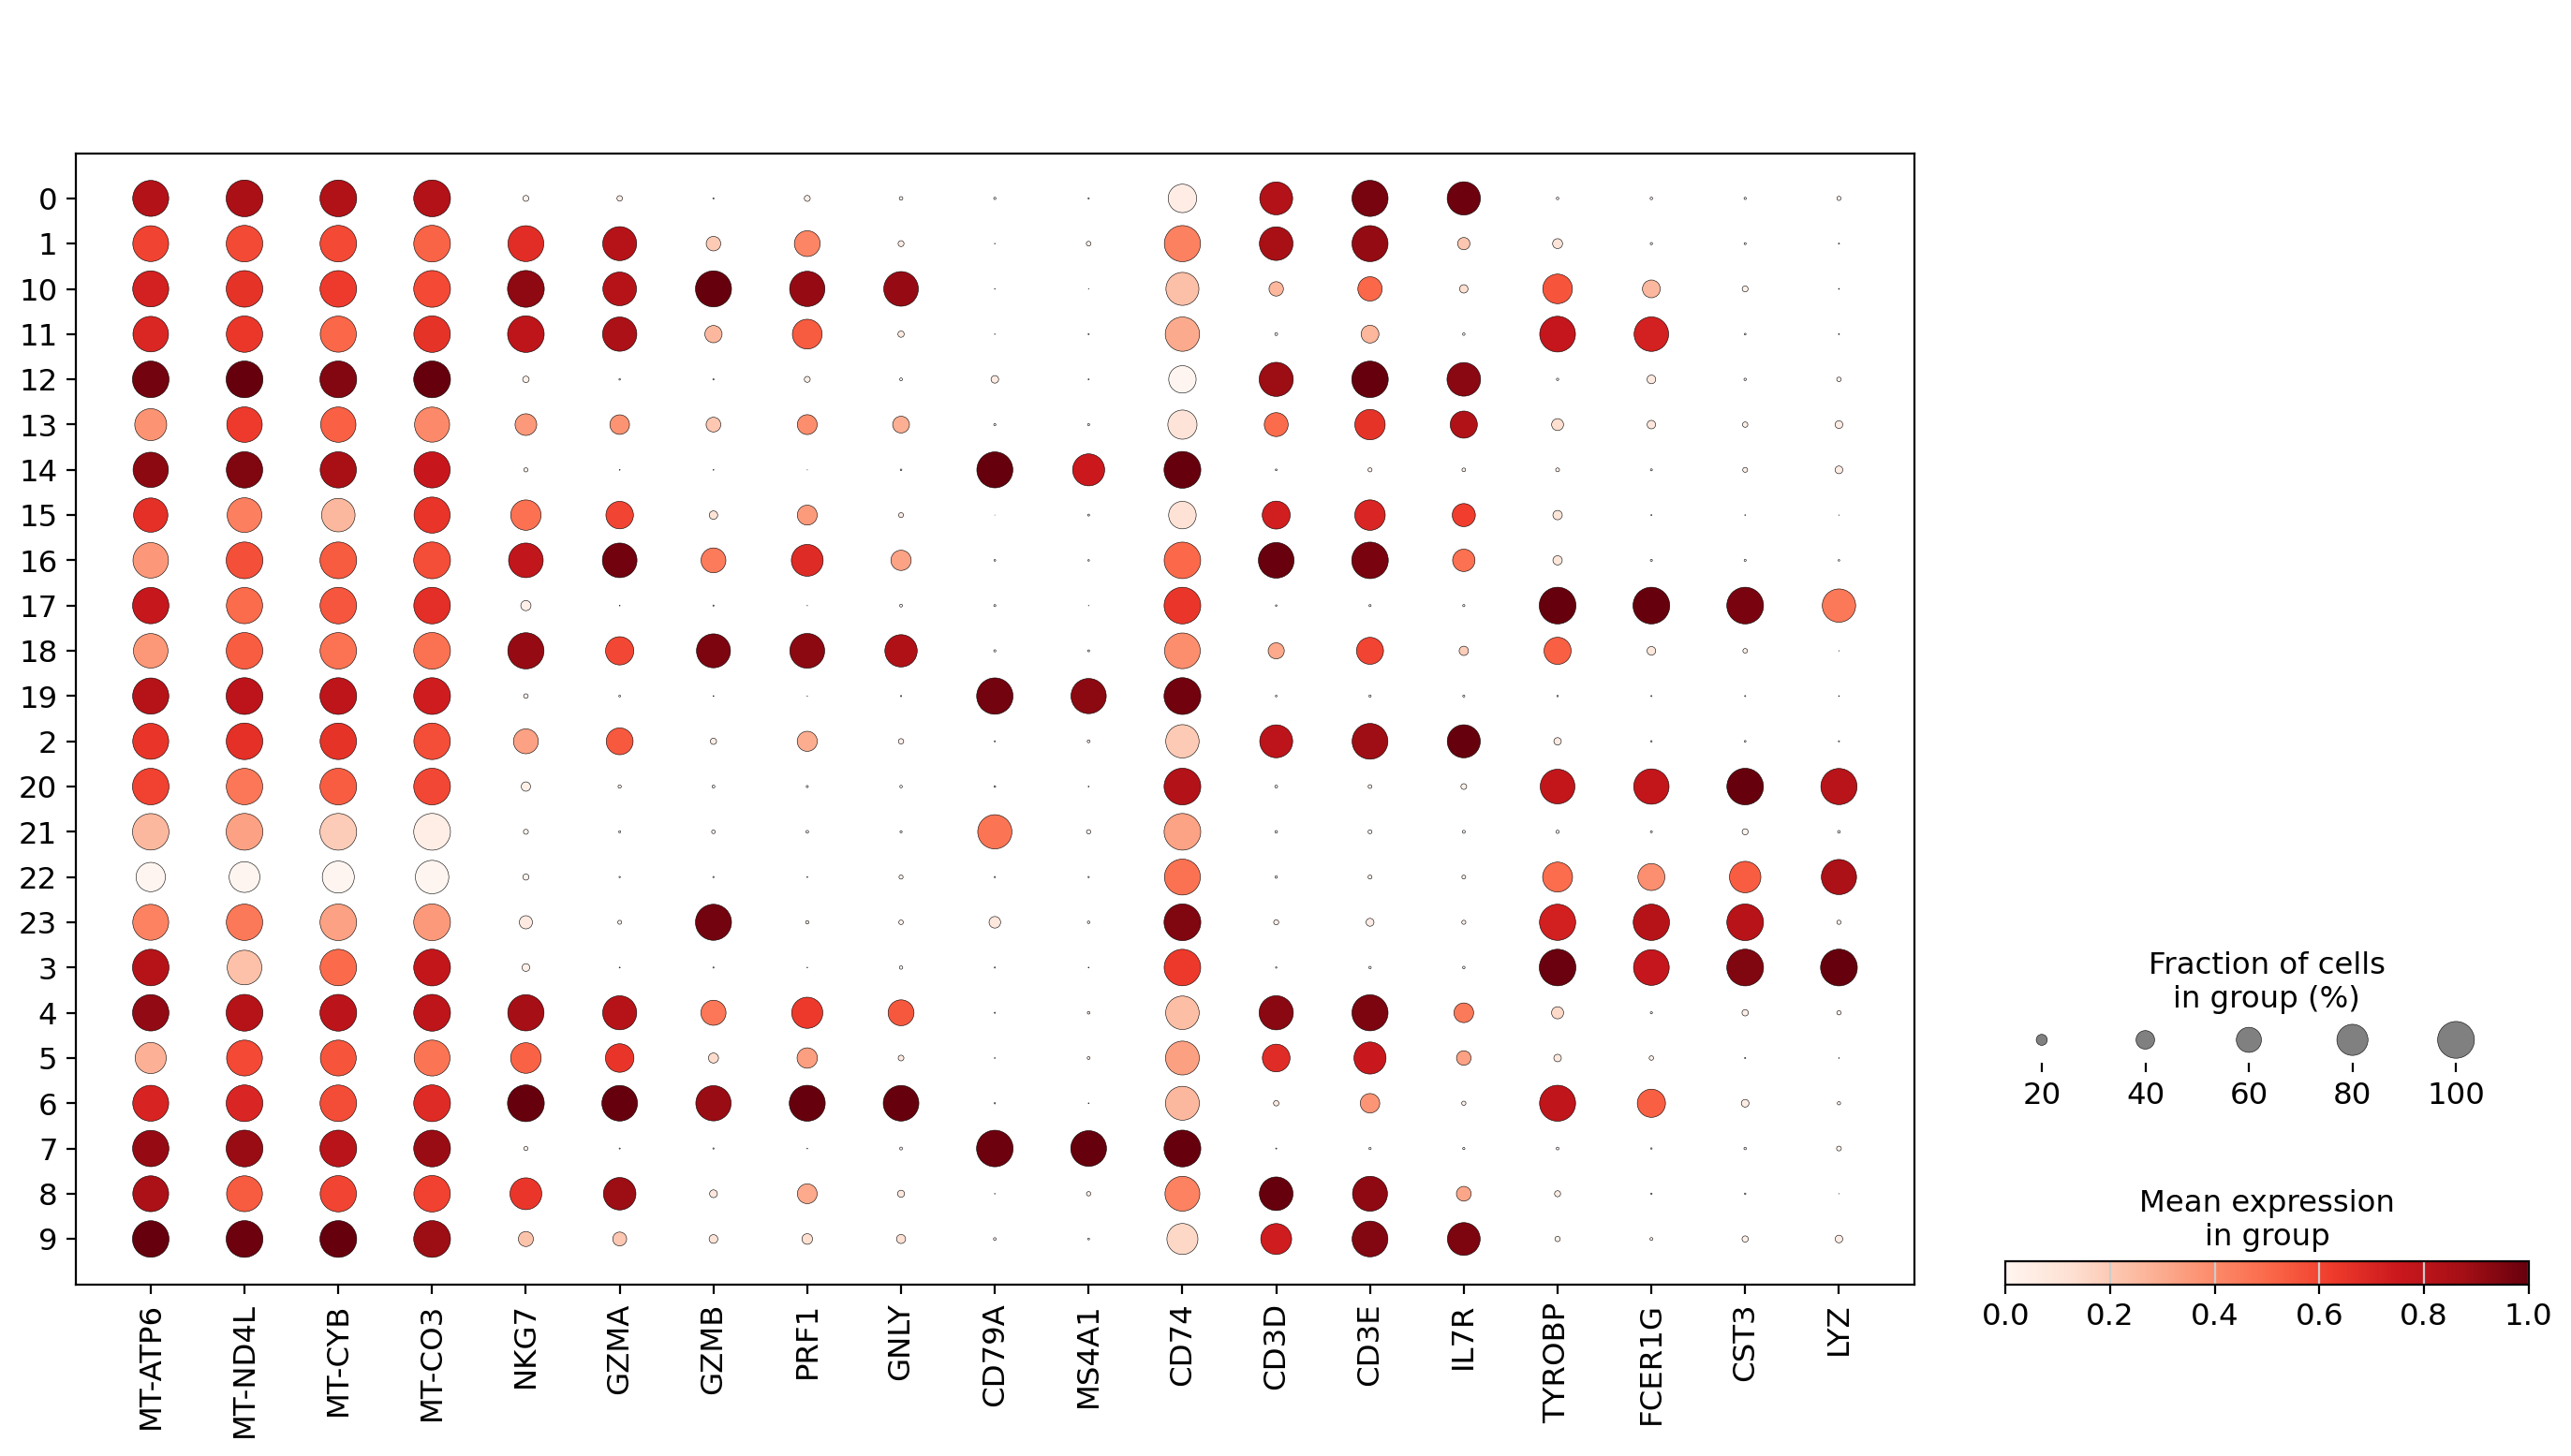

In [22]:
# Dotplot: Key clusters marker genes
key_markers = ['MT-ATP6', 'MT-ND4L', 'MT-CYB', 'MT-CO3',  # Mitochondrial
               'NKG7', 'GZMA', 'GZMB', 'PRF1', 'GNLY',    # NK/Cytotoxic
               'CD79A', 'MS4A1', 'CD74',                   # B cell
               'CD3D', 'CD3E', 'IL7R',                     # T cell
               'TYROBP', 'FCER1G', 'CST3', 'LYZ']          # Myeloid

# 존재하는 marker만 선택
available_markers = [m for m in key_markers if m in adata.var_names]
print(f"Available markers: {len(available_markers)}/{len(key_markers)}")

if len(available_markers) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    sc.pl.dotplot(adata, available_markers, groupby=CLUSTER_COL,
                  ax=ax, show=False, standard_scale='var')
    plt.tight_layout()
    plt.savefig(session2_path / 'figures' / 'key_markers_dotplot.png',
                dpi=150, bbox_inches='tight')
    plt.show()

---
## 8. Save Results

In [23]:
# FM-GSEA 결과 저장
print("FM-GSEA 결과 저장 중...\n")

for cluster, results in fm_gsea_results.items():
    for gs_name, df in results.items():
        if df is not None and len(df) > 0:
            filename = f'cluster{cluster}_{gs_name}_enrichment.csv'
            filepath = session2_path / 'fm_gsea' / filename
            df.to_csv(filepath, index=False)
            print(f"  ✓ {filename}")

print("\n✓ 모든 결과 저장 완료")

FM-GSEA 결과 저장 중...

  ✓ cluster9_kegg_enrichment.csv
  ✓ cluster9_hallmark_enrichment.csv
  ✓ cluster9_go_bp_enrichment.csv
  ✓ cluster9_reactome_enrichment.csv
  ✓ cluster14_kegg_enrichment.csv
  ✓ cluster14_hallmark_enrichment.csv
  ✓ cluster14_go_bp_enrichment.csv
  ✓ cluster14_reactome_enrichment.csv
  ✓ cluster22_kegg_enrichment.csv
  ✓ cluster22_hallmark_enrichment.csv
  ✓ cluster22_go_bp_enrichment.csv
  ✓ cluster22_reactome_enrichment.csv
  ✓ cluster15_kegg_enrichment.csv
  ✓ cluster15_hallmark_enrichment.csv
  ✓ cluster15_go_bp_enrichment.csv
  ✓ cluster15_reactome_enrichment.csv
  ✓ cluster18_kegg_enrichment.csv
  ✓ cluster18_hallmark_enrichment.csv
  ✓ cluster18_go_bp_enrichment.csv
  ✓ cluster18_reactome_enrichment.csv
  ✓ cluster20_kegg_enrichment.csv
  ✓ cluster20_hallmark_enrichment.csv
  ✓ cluster20_go_bp_enrichment.csv
  ✓ cluster20_reactome_enrichment.csv
  ✓ cluster23_kegg_enrichment.csv
  ✓ cluster23_hallmark_enrichment.csv
  ✓ cluster23_go_bp_enrichment.csv
  ✓ clu

---
## 9. Cell Type Annotation (기반 정보)

In [24]:
# 클러스터별 추정 cell type 및 특징
# (marker gene 분석 결과 기반으로 업데이트 필요)

cluster_info = pd.DataFrame({
    'Cluster': list(range(24)),
    'Category': [''] * 24,
    'Cell_Type': [''] * 24,
    'Key_Feature': [''] * 24
})

# IT-exclusive
for c in IT_EXCLUSIVE:
    cluster_info.loc[c, 'Category'] = 'IT-exclusive'

# NL-dominant
for c in NL_DOMINANT:
    cluster_info.loc[c, 'Category'] = 'NL-dominant'

# IT-enriched
for c in IT_ENRICHED:
    cluster_info.loc[c, 'Category'] = 'IT-enriched'

# 나머지
for c in range(24):
    if cluster_info.loc[c, 'Category'] == '':
        cluster_info.loc[c, 'Category'] = 'Mixed'

# 저장
cluster_info.to_csv(session2_path / 'cluster_annotation_template.csv', index=False)
print("클러스터 annotation 템플릿 저장:")
print(cluster_info[cluster_info['Category'] != 'Mixed'].to_string())
print(f"\n✓ 저장: cluster_annotation_template.csv")
print("\n→ Cell_Type 및 Key_Feature 컬럼을 marker gene 결과 기반으로 채워주세요.")

클러스터 annotation 템플릿 저장:
    Cluster      Category Cell_Type Key_Feature
9         9  IT-exclusive                      
14       14  IT-exclusive                      
15       15   NL-dominant                      
18       18   NL-dominant                      
20       20   IT-enriched                      
22       22  IT-exclusive                      
23       23   IT-enriched                      

✓ 저장: cluster_annotation_template.csv

→ Cell_Type 및 Key_Feature 컬럼을 marker gene 결과 기반으로 채워주세요.


---
## 10. Summary Report

In [25]:
# Session 2 Summary
summary = f"""
# ITLAS Session 2 Summary Report
## FM-GSEA & Pathway Analysis

**Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}

---

## 1. Data Overview

- **File**: GSE182159_with_leiden.h5ad
- **Cells**: {adata.shape[0]:,}
- **Genes**: {adata.shape[1]:,}
- **Clusters**: 24 (Leiden, resolution=0.438)

## 2. Key Clusters Analyzed

### IT-Exclusive (NL < 1%)
- Cluster 9: NL=0.03%, CR-dominant
- Cluster 14: NL=0.36%, CR-enriched
- Cluster 22: NL=0.00%, IT=12.4%

### NL-Dominant (NL > 97%)
- Cluster 15: NL=97.4%
- Cluster 18: NL=99.9%

### IT-Enriched (IT > 30%)
- Cluster 20: IT=57.4%
- Cluster 23: IT=33.5%

## 3. Pathway Analysis

- Gene sets: KEGG, Hallmark, GO_BP, Reactome
- Method: Enrichr (gseapy)

## 4. Files Generated

```
results/session2_pathway/
├── fm_gsea/
│   ├── all_cluster_markers.csv
│   ├── cluster*_kegg_enrichment.csv
│   ├── cluster*_hallmark_enrichment.csv
│   └── ...
├── figures/
│   ├── IT_exclusive_KEGG_heatmap.png
│   ├── IT_exclusive_Hallmark_heatmap.png
│   ├── All_key_clusters_KEGG_heatmap.png
│   └── key_markers_dotplot.png
└── cluster_annotation_template.csv
```

## 5. Next Steps (Session 3)

1. Cell type annotation 완성
2. IT-immunopathogenesis theory 개발
3. Publication figures 생성
4. Manuscript Results/Discussion 작성

---
*Generated by ITLAS Session 2 Pipeline*
"""

# 저장
with open(session2_path / 'Session2_Summary_Report.md', 'w', encoding='utf-8') as f:
    f.write(summary)

print(summary)


# ITLAS Session 2 Summary Report
## FM-GSEA & Pathway Analysis

**Date**: 2026-01-30 10:57

---

## 1. Data Overview

- **File**: GSE182159_with_leiden.h5ad
- **Cells**: 243,000
- **Genes**: 24,452
- **Clusters**: 24 (Leiden, resolution=0.438)

## 2. Key Clusters Analyzed

### IT-Exclusive (NL < 1%)
- Cluster 9: NL=0.03%, CR-dominant
- Cluster 14: NL=0.36%, CR-enriched  
- Cluster 22: NL=0.00%, IT=12.4%

### NL-Dominant (NL > 97%)
- Cluster 15: NL=97.4%
- Cluster 18: NL=99.9%

### IT-Enriched (IT > 30%)
- Cluster 20: IT=57.4%
- Cluster 23: IT=33.5%

## 3. Pathway Analysis

- Gene sets: KEGG, Hallmark, GO_BP, Reactome
- Method: Enrichr (gseapy)

## 4. Files Generated

```
results/session2_pathway/
├── fm_gsea/
│   ├── all_cluster_markers.csv
│   ├── cluster*_kegg_enrichment.csv
│   ├── cluster*_hallmark_enrichment.csv
│   └── ...
├── figures/
│   ├── IT_exclusive_KEGG_heatmap.png
│   ├── IT_exclusive_Hallmark_heatmap.png
│   ├── All_key_clusters_KEGG_heatmap.png
│   └── key_markers_dot

In [26]:
# 최종 확인
print("="*60)
print("SESSION 2 완료")
print("="*60)

print(f"\n[생성된 파일]")
for folder in ['fm_gsea', 'figures']:
    folder_path = session2_path / folder
    files = list(folder_path.glob('*'))
    print(f"\n  {folder}/")
    for f in files[:10]:  # 최대 10개
        print(f"    - {f.name}")
    if len(files) > 10:
        print(f"    ... 외 {len(files)-10}개")

print(f"\n\n✓ Session 2 분석 완료!")
print(f"✓ 결과 위치: {session2_path}")

SESSION 2 완료

[생성된 파일]

  fm_gsea/
    - all_cluster_markers.csv
    - cluster9_kegg_enrichment.csv
    - cluster9_hallmark_enrichment.csv
    - cluster9_go_bp_enrichment.csv
    - cluster9_reactome_enrichment.csv
    - cluster14_kegg_enrichment.csv
    - cluster14_hallmark_enrichment.csv
    - cluster14_go_bp_enrichment.csv
    - cluster14_reactome_enrichment.csv
    - cluster22_kegg_enrichment.csv
    ... 외 19개

  figures/
    - IT_exclusive_KEGG_heatmap.png
    - IT_exclusive_Hallmark_heatmap.png
    - All_key_clusters_KEGG_heatmap.png
    - key_markers_dotplot.png


✓ Session 2 분석 완료!
✓ 결과 위치: /content/drive/MyDrive/ITLAS/results/session2_pathway
